In [ ]:
import sys
sys.path.append('..')

# Support Vector Machines (SVMs)

## Learning objectives
- understand how SVMs work
- understand how the kernel trick always makes space separable
- use the SkLearn library to implement a SVM

## Intro - Which decision boundary is better?

Support vector machines can be used for both classification and regression. For now, we will focus on the classification problem.

![](images/svm/svm_which_boundary_is_best.jpg)

One way to choose which decision boundary is best would be to find the one which separates the different classes by the greatest margin.


## What is a support vector machine?

SVMs produce point estimates for either regression or classification problems. 
It does not output probabilities like logistic regression or predict the most likely value from a distribution like in linear regression.
The decision boundary that they produce is characterised by having the margin of the greatest possible width.

![](images/svm/svm_margin_diagram.jpg)

We will start by looking at how SVMs handle binary classification, for data that is linearly separable.

This is different but similar to how logistic regression performs classification, 
logistic regression considers all of the points to determine the best hyperplane, whereas SVMs only consider the support vectors.
Outliers will influence the decision boundary for logistic regression as a result, but would not do so for an SVM.

Like linear and logistic regression, we can start building a SVM using a linear function. This linear function will depend on both a vector of weights and a bias, so SVMs are parametric models.
In the classification case SVMs predict true if the model output is positive and false if negative.

The desicion boundary is given by:
# $$h(x) = wx + b = 0$$

That means that any point which evaluates to $h(x) = 0$ is directly on the decision boundary.

The classification is made by the function 

# $output\ classification = sign(h(x)) = sign(wx + b)$

For any examples that the SVM will classify as positive, $h(x) \geq 0$.
For any examples that the SVM will classify as negative, $h(x) \leq 0$.

For binary classification using SVMs, the labels are not 1 or 0 like we have seen up to this point.
Instead, the labels are +1 or -1.

Some examples within each class will lie directly on the boundary of the margin, where $f(x) = +1$ for positive examples, and $f(x) = -1$ for negative examples.
These examples are known as the support vectors.
We will talk further about how the support vectors are found soon.

![](images/svm/svm_support_vectors_diagram.jpg)

SVMs make a point estimate, rather than outputting a probability or a probability distribution.

## What is the objective function?
How can we quantify the size of the boundary as a function of our data and our model parameters? 

As mentioned, we want to maximise the margin, so that examples are separated by as much space as possible.
We could get an expression for the width of the margin by projecting a vector that crosses from one side of the margin to the other in a direction perpendicular to the decision boundary.
How can we get these 2 things?

![](images/svm/svm_quantifying_margin_width1.jpg)
![](images/svm/svm_quantifying_margin_width2.jpg)

### Isn't the optimal parameterisation a zero vector then?

If the whole objective function were to maximise the width of the margin, given by $\frac{2}{||\omega||}$ (or equivalently minimise $||w||$), then yes, a zero vector would optimise the objective.
But, we need to optimise that subject to some constraint, which will add terms to the loss function.
So the expression $\frac{2}{||\omega||}$ is not the entire objective that we are trying to maximise.

The constraint is that all of our examples must be classified correctly (assuming that they are linearly separable, and hence are possible to separate with this simple model's decision hyperplane, for the moment).

![](images/svm/svm_classification_constraint_cases.jpg)

Combining the unconstrained margin width objective with the constraint:

![](images/svm/svm_separable_obj_no_kernel.jpg)

In practice, we optimise the **squared** $L^2$ norm ,$||w||^2$, rather than the $L^2$ norm, which has the same optima.
This is 1) because it is easier to compute (no need to square root) and 2) because the gradient of the loss surface is steeper, so the optimisation can be faster

We could also reach the same optima by minimising the $L^1$ norm, which again has the same optima. 
But then the second derivative of the loss function is zero, so when using gradient descent, the algorithm moves towards the optima at the same rate regardless if it is close or far.

## Training your support vector machine

Because the objective is quadratic with linear inequality constraints, it is convex. That means that any optima will be a global optima.

So far we have not looked at how we can computationally solve **constrained** optimisation problems.
We have however looked at techniques, like gradient descent, which can solve **unconstrained** optimisation problems quickly.
Fortunately, we can always convert constrained optimisation problems as unconstrained optimisation problems by finding their **Lagrangian**.

Constrained optimisation is out of scope of this course. 
As such, this is the only model that we wont implement from scratch.

The math of the process of finding the Lagrangian is out of scope, but it's not that hard and you can see it explained clearly [here](https://www.youtube.com/playlist?list=PLcQcj4VuyilM-I4Zyagqdg6TtAjFH4IqO).

# show constrained original, primal lagrangian and dual lagrangian objective, then unconstrained objective with lagrange multipliers.

Check out how SVMs are fit [here](https://web.stanford.edu/~hastie/Papers/ESLII.pdf#700).

Furthermore, a particular optimisation algorithm was developed specifically for optmising the dual objective formulation for SVMs (particularly with kernels, which we will discuss later).
It is known as [Sequential Minimal Optimisation (SMO)](https://en.wikipedia.org/wiki/Sequential_minimal_optimization).

## The result
We need not worry about the process of finding the unconstrained formulation of the objective function. What we need to be concerned with is the result of it's optimisation.

Notice that in the dual form of the Lagrangian, our loss function is not dependent on $\omega$, but on $\alpha$.

We will later see that the decision hyperplane can too be equivalently expressed in terms of $\alpha$ rather than $\omega$, as shown below:

## $$f(x) = wx + b = \Sigma_i^m \alpha_i x^Tx_i$$

So we now need to find the parameter vector $\alpha$ rather than $\omega$.

$\alpha$ is a vector where each element corresponds to a single example.
Each $\alpha$ controls the contribution of the corresponding example to the loss function.
After optimisation, most of the $\alpha$ will be 0.
Only the $\alpha$ corresponding to the **support vectors** will be non-zero.
This indicates that the decision hyperplane depends only on these support vectors, which lie along the margin boundaries.

# diagram showing alphas of example points

## SkLearn implementation

Firstly let's make some data


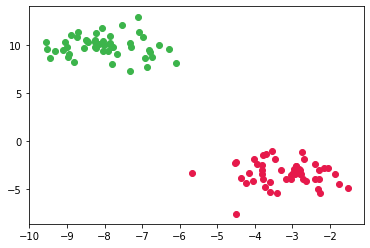

In [6]:
# import numpy as np
# np.set_printoptions(suppress=True)
# import matplotlib.pyplot as plt
# import sklearn.datasets
# from get_colors import colors

# def get_data(sd=6, m=100, n_features=2, n_clusters=2):
#     X, Y = sklearn.datasets.make_blobs(n_samples=m, n_features=n_features, centers=n_clusters, cluster_std=sd)
#     return X, Y

# def show_data(X, Y, predictions=None):
#     for i in range(min(Y), max(Y)+1):
#         y = Y == i
#         x = X[y]
#         plt.scatter(x[:, 0], x[:, 1], c=colors[i])
#         if predictions is not None:
#             y = predictions == i
#             x = X[y]
#             plt.scatter(x[:, 0], x[:, 1], c=colors[i], marker='x', s=100)
#     plt.show()

# m = 100
# n_features = 2
# n_classes = 2
# X, Y = get_data(0.5, m, n_features, n_classes)

import sys
sys.path.append('..')
from utils import get_classification_data, show_data
X, y = get_classification_data(sd=1, m=100)
show_data(X, y)

## Sklearn implementation

[0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0
 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0
 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0]


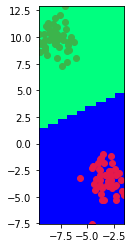

In [7]:
import sklearn.svm
from get_colors import colors
from utils import colors, visualise_predictions

svm = sklearn.svm.SVC(kernel='linear')

svm.fit(X, y)

predictions = svm.predict(X).astype(int)

print(predictions)

visualise_predictions(svm.predict, X, y)


## What if my data is not linearly separable?

In the case where the data cannot be split by a linear hyperplane, it is not possible to satisfy the constraints of the optimisation objective.
Because this constraint *must* be met, we call the objective function that uses it the **hard margin** formulation.

Conversely, there is a formulation of the loss function which relaxes this constraint.
It still penalises misclassified examples, but allows for them when no perfect split can be made.
It is called the **soft margin** formulation of the objective function.

### What is the soft margin?
A soft margin allows some examples to be on the incorrect side of the decision hyperplane, whilst still penalising them.

If a straight line that separates the examples of each class can not be found, we can give the model some slack and allow some examples to be misclassified. Each example, $x^{(i)}$ then gets an associated parameter $\xi_i$, which is it's proportional perpendicular distance between it's correct margin boundary, and the decision boundary (see diagram below).

![](images/svm_xi.jpg)
![](images/svm_xi_cases.jpg)

To implement the soft margin objective function, the hard constraint is removed and an extra term is added to the loss function that penalises the objective proportionally to the distance between the point and the decision boundary, if the datapoint is within the margin or on the wrong side of it.

The larger $C$, the less errors are tolerated.

# soft margin loss function 

$C = \infty$ defines a hard margin SVM (infinite penalty for any misclassification)


# draw the new objective function with misclassification constraint

### Why allow a soft margin?
#### Non-separable data
The hard margin will not provide a solution if the data is not linearly separable.

In this case, we will have to change our objective function to tolerate some error. 
In the next section we will discuss how to quantify the amount of error tolerated.

#### Overfitting

Some examples may be outliers. Which we dont to influence the decision hyperplane. Doing so may make our model too specific to the training data and cause overfitting. 

We can apply some regularisation to the model to improve the generalisation error.

# ignoring outlier to 

This can make the margin larger. The width of the margin is the distance by which support vectors of opposite classes are separated. If they are separated by a larger region, it's more obvious what class they belong too, and we can have more confidence in our predictions.

# diagram of larger margin 

A larger margin means a greater confidence zone.

![](images/svm/svm_effect_of_c.jpg)

In [ ]:
X, Y = get_data(5)
show_data(X, Y)

Let's fit an SVM to this data which is not linearly separable, using a hard margin. I.E. $C=\infinity$

In [ ]:
# svm = sklearn.svm.SVC(kernel='linear', C=1000000000000000000000000)#float('inf'))

# svm.fit(X, Y)
# print('number of support vectors:', svm.n_support_)

# predictions = svm.predict(X).astype(int)
# visualise_predictions(svm.predict, X)
# show_data(X, Y)


Above we can see that the code keeps running indefinitely as there is no minima.
Every decision hyperplane will result in some misclassification.
Each misclassified example will have a non-zero slack variable which is then multiplied by $C$, that is by infinity.
Everywhere on the loss surface will be at this constant infinite value, so there is no optima.

now the SVM is not capable of drawing a linear decision boundary that splits the data and classifies it correctly.


The default value for $C$ is 1.

Let's try out some different values for $C$.



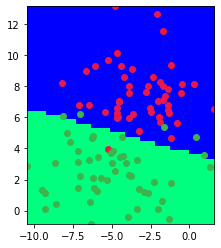

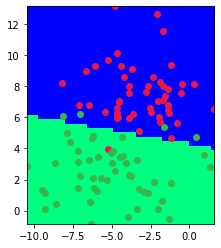

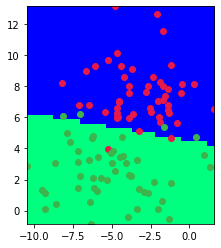

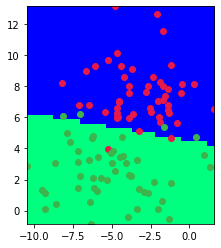

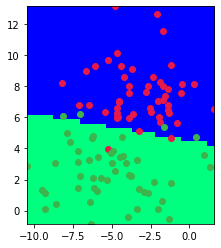

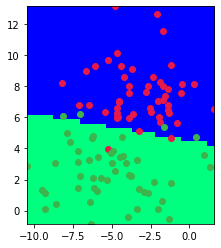

In [11]:
cs = [0.01, 0.1, 1, 10, 100, 1000]

X, y = get_classification_data(sd=2, m=100)

for c in cs:
    svm = sklearn.svm.SVC(kernel='linear', C=c)
    svm.fit(X, y)
    visualise_predictions(svm.predict, X, y)

# Kernels

However, it is easy to imagine a case where the data is not linearly separable, but may be easily split, perfectly by some non-linear decision boundary.
For example, look at the data below.

number of support vectors: [50 50]


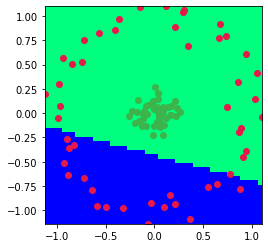

In [18]:
X, y = get_classification_data(m=100, noise=0.1, variant='circles')
svm = sklearn.svm.SVC(kernel='linear')
svm.fit(X, y)
print('number of support vectors:', svm.n_support_)
predictions = svm.predict(X).astype(int)
visualise_predictions(svm.predict, X, y)

The data is again, not linearly separable. 
But in this case you can imagine a circular decision boundary within the outer class that would easily split the data perfectly.


# zisserman diagram

Above, we have applied a function to create a new transformation of each example, and we can draw a straight line in this new transformed space that correctly separates the data.

We can project examples into a (usually higher dimensional) space where it is linearly separable.

When this boundary is projected back into the original space, it can be highly nonlinear, as we will see.

# showing how the circles data is linearly separable in transformed space, but that the decision boundary in the original space is circles 

## Kernels
Kernels allow us to write the hypothesis in terms of weighted inner products between examples.

# diagram to show this^

---

For example, there exists a vector $\alpha$ such that
## $f(x) = wx + b = \Sigma_i^m \alpha_i x^Tx_i$

# show equivalence of above with examples
# find some parameters drawn diagram

Kernel functions take the form of an inner product between two vectors that have been transformed by some function:

# $$ K(x, x_i) = \phi(x) \cdot \phi(x_i) $$

So in our case, we can express the hypothesis as 
# $$ f(x) = \Sigma_i^m \alpha_i K(x, x_i) $$

### What does this mean intuitively?

As you know, a dot product between examples x and x_i is often used to compare their similarity.
So we can consider this view of a hypothesis as a template matching procedure asking: 

"which examples in the dataset should each input be compared to, and does similarity make the input more or less likely a member of the positive class?".

Furthermore, only the support vectors will have non-zero alphas, so the procedure is more like: 

"which **support vectors** should each input be compared to, and does similarity make the input more or less likely a member of the positive class?".

---

Before taking this inner product between examples, we can transform each example in feature space.
This is reasonable because it's like you measured different features rather than the ones you have by default. 
E.g. you record floor area of a house rather than just width and length, which is a feature that could be produces by a transformation combining them both.
Once the raw features have been transformed into a new arrangement, they may then be linearly separable!

The hypothesis would then become
## $h(x) = w \phi(x) + b$
where $\phi(x)$ is the input transformed into the new space by the function $\phi$.

The problem is that the transformation which is required to make the data linearly separable may be extremely complicated, and hard to find.
This is where something called the **kernel trick** comes in.

## The Kernel Trick

The Kernel Trick is a mathematical trick that means that we don't even need to know what transformation we are applying to our original data.

### What's the advantage of expressing the hypothesis in terms of a kernel function?

We could use any function to transform the original features.
The kernel function then computes the dot product between the input and another example after they have undergone that transformation.
A transformation with this capacity may be computationally expensive to apply, especially to every example.

The **trick** is that we don't actually apply \phi to each example. 
Instead, we use kernel functions that take in both the current input, and the example to compare it with, and perform a computationally cheap transformation **that is equivalent** to the dot product between the two examples after they've had \phi applied.

Below are some examples of the most popular kernel functions that illustrate this.

![](images/svm_kernel_trick.png)
![](images/svm_poly_kernel.png)
![](images/svm_rbf_kernel.png)

To evaluate $K$, we don't need any knowledge of $\phi$ at all! This is the Kernel Trick.


## SkLearn implementation

number of support vectors: [7 6]


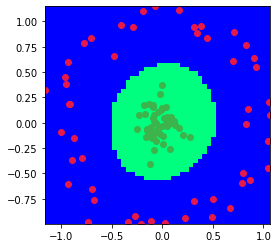

In [20]:
X, y = get_classification_data(m=100, noise=0.1, variant='circles')
svm = sklearn.svm.SVC(kernel='rbf')
svm.fit(X, y)
print('number of support vectors:', svm.n_support_)
predictions = svm.predict(X).astype(int)
visualise_predictions(svm.predict, X, y)

## Try out the different kernels

Look at the sklearn documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and run the same code as above with different kernels.

In [ ]:
class LinearKernel:
    def __init__(self, X):
        self.X = X

    def linear_kernel(x):
        k = np.dot(X, x) # template match against all other examples
        return k

class SVM:
    def __init__(self, n_features=2, n_classes=10):
        self.w = np.random.rand(n_features, n_classes)
        self.b = np.random.rand(n_classes)

    def predict(self, x):
        h = np.matmul(x, self.w) + self.b
        return np.sign(h)